We deployed [the new M-Lab platform to 1/3rd of the M-Lab fleet](http://example.com), and now we
need to assess whether or not it is a performance regression, relative to the
old platform.  As long as we can be sure the performance of the new platform
does not constitute a regression, then we can roll out the new platform to
2/3rds of the fleet, redo this analysis in a pro-forma way to make sure nothing
has gone wrong after the 1/3rd to 2/3rds rollout, and then roll out the new
platform to the remaining nodes around the world.

More concretely, for every site, we would like to be certain, at the 95% level
or above, that the performance data gathered on the new platform is not worse
(lower bandwidth, higher latency) than the old platform at that same site.

We are in a situation that is an almost textbook case for statistical analaysis:
1. We have a lot of data
2. We have a question of interest (is the new platform at least as performant as
   the old platform?)
3. We have a default action (roll out the new platform to 2/3rds of the fleet)

In developing an analysis, we want to be congnizant of a few important facts:
1. Internet performance is differently variable in different regions of the
   world.
2. Not all machines at a site are used equally. In particular, we know of some
   NDT clients which will ONLY run a test to `ndt.iupui.mlab1.lax03` and would
   never run a test to `ndt.iupui.mlab2.lax03` or `ndt.iupui.mlab3.lax03`.
3. The kubernetes platform is not rolled out to any `mlab1` machines.

Our needs and our constraints lead to the following per-site analysis method to
decide whether the new platform is not a regression at a given site:

Let us assume that for this site, the `mlab2` machine uses PlanetLab, vservers,
and web100 (a PL machine) and the `mlab3` machine uses Kubernetes, Docker, and tcp-info (a k8s machine).
1. Calculate the mean and median download, upload, and latency experienced by
   all NDT clients that connected to `mlab2` or `mlab3` during the month of
   September.  If the mean and median for the new platform are both not worse
   than the mean and median for the old platform, then we are done.  The
   performance of the new platform at that site does not constitute a
   regression.
2. If either of the mean or median upload speed, download speed, or RTT have
   regressed, then we calculate a "noise floor" for the site by doing the same
   analysis for January, February, ..., June of 2019.  During those months, all
   the `mlab3` machines were controlled by the old platform and as such, our
   monthly variation between sample means establishes a "noise floor".  We then
   compare the new difference (between the new and old) to the established noise
   floor (between the old and the old) to see whether it is within historical
   norms.  If we are 95% confident that the new performance differential is
   within historical norms, then we can conclude that the new performance at the
   site does not constitue a regression.
3. If the regression in performance is outside of historical norms, we conduct
   an investigation to discover why.

Armed with this analysis method, we set about investigating M-Lab's Bigquery NDT
data.  We begin by calculating a maximum per-client performance to each machine
at the site, to prevent any
individual network endpoint from contributing too much to the final analysis.
We then compare the mean and median of these "monthly bests" between the PL and
k8s.

We first begin by constructing a basic query that filters out some bad-looking data and then creates two joinable tables containing per-site performance at the 0%, 10%, ... 90%, and 100% levels as well as per-site average performance.  Once we have both of these, we conduct two analyses: a visual one and a quantitative one.

In [1]:
client_per_day = '''#standardSQL
###################################################################################
# This extracts standard fields that we want for merging/comparing with NDT5 data.
# The connection_spec.* is temporary, and will be further standardized.
# partition_date, log_time, uuid, iata, site, machine, client_ip, protocol, mbps, connection_spec.*

WITH pl_base AS (
SELECT partition_date,
  REGEXP_EXTRACT(task_filename, ".*mlab[1-4].*-(.*)[0-9t]{2}-.*") AS iata,
  REGEXP_EXTRACT(task_filename, ".*mlab[1-4].*-([a-z0-9]{5})-.*") AS site,
  REGEXP_EXTRACT(task_filename, ".*(mlab[1-4]).*-.*-.*") AS machine, 
  IF (connection_spec.websockets, IF (connection_spec.tls, "WSS", "WS"), "PLAIN") AS protocol,
  * EXCEPT (partition_date)
FROM `mlab-oti.ndt.downloads`
WHERE partition_date >= "2019-01-01"
),

pl AS (
SELECT
  partition_date, log_time,
  test_id AS uuid, iata, site, machine, connection_spec.client_ip AS client_ip,
  protocol, 
  alpha.mean_download_throughput_mbps AS mbps,
  (web100_log_entry.snap.SndLimTimeRwin +
   web100_log_entry.snap.SndLimTimeCwnd +
   web100_log_entry.snap.SndLimTimeSnd) / 1000000.0 as duration,
  connection_spec,  # Included because it has other things we might need.
  web100_log_entry.snap  # Included because it has other things we might need.
FROM pl_base
WHERE
  connection_spec.client_ip NOT IN(
    "", "45.56.98.222", "35.192.37.249", "35.225.75.192",
    "2600:3c03::f03c:91ff:fe33:819", "23.228.128.99", "2605:a601:f1ff:fffe::99")
),

###################################################################################
# This extracts standard fields that we want for merging/comparing with web100 data.
# The S2C.* is temporary, and will be further standardized.
# partition_date, log_time, uuid, iata, site, machine, client_ip, protocol, mbps, duration, S2C.*

ndt5_base AS (
SELECT partition_date, result.S2C.StartTime AS log_time, result.S2C.UUID as uuid,
  REGEXP_EXTRACT(ParseInfo.TaskFileName, ".*mlab[1-4].*-(.*)[0-9t]{2}-.*") AS iata,
  REGEXP_EXTRACT(ParseInfo.TaskFileName, ".*mlab[1-4].*-([a-z0-9]{5})-.*") AS site,
  REGEXP_EXTRACT(ParseInfo.TaskFileName, ".*(mlab[1-4]).*-.*-.*") AS machine, 
  result.S2C.ClientIP AS client_ip,
  result.Control.Protocol AS protocol,
  result.S2C
FROM `mlab-oti.ndt.ndt5`
WHERE
  result.S2C IS NOT NULL
  AND result.S2C.ClientIP IS NOT NULL
),

ndt5 AS (
SELECT
  partition_date, log_time, uuid,
  iata, site, machine,
  client_ip, protocol, 
  S2C.MeanThroughputMbps+.032 AS mbps,  # NOTE adjustment for truncation
  TIMESTAMP_DIFF(S2C.EndTime, S2C.StartTime, MILLISECOND)/1000 as duration,
  S2C  # Included because it has other things we may need.
FROM ndt5_base
WHERE
  client_ip NOT IN(
    "", "45.56.98.222", "35.192.37.249", "35.225.75.192",
    "2600:3c03::f03c:91ff:fe33:819", "23.228.128.99", "2605:a601:f1ff:fffe::99")
),

###################################################################################
# Select one query per client per day per mlab2/3 machine.

merged AS (
SELECT "pl" AS type, TIMESTAMP_TRUNC(log_time , HOUR) AS hour, * EXCEPT (connection_spec, snap),
snap.MinRTT
FROM pl
UNION ALL
SELECT "ndt5" AS type, TIMESTAMP_TRUNC(log_time , HOUR) AS hour, * EXCEPT (S2C), S2C.MinRTT/1000000
FROM ndt5
),

client_per_day AS (
  SELECT * EXCEPT(row_number) FROM (
    SELECT *, ROW_NUMBER() OVER (PARTITION BY CONCAT(type, machine, client_ip, CAST(TIMESTAMP_TRUNC(log_time, DAY) AS STRING)) ORDER BY FARM_FINGERPRINT(uuid)) AS row_number FROM merged)
  WHERE row_number = 1
),

'''


In [2]:
from google.cloud import bigquery
client = bigquery.Client(project='measurement-lab')

# TODO - should choose the client count lower limit based on number of clients in the prefix.
prefix_query = client_per_day + '''
###################################################################################
# Aggregate by machine and client prefix xxxx:yyyy or aaa.bbb.
# label by type (legacy or ndt5) and report median MinRTT and MBPS per prefix 
# across all machines.

pilot_wss_prefix_metrics AS (
SELECT 
iata,  protocol, type, COUNT(*) AS tests, COUNT(DISTINCT HOUR) as hours,
REGEXP_EXTRACT(client_ip, "([a-f0-9]{1,4}[:.]{1}[a-f0-9]{1,4}[:.]{1}).*") AS prefix,
ROUND(APPROX_QUANTILES(mbps,20)[OFFSET(10)],3) as median_mbps,
ROUND(APPROX_QUANTILES(MinRTT,20)[OFFSET(10)],3) as median_min_rtt,
ROUND(POWER(10,AVG(LOG10(IF(mbps > 0, mbps, .0001)))),3) as log_avg,
ROUND(POWER(10,STDDEV(LOG10(IF(mbps > 0, mbps, .0001)))),3) AS log_stdev
FROM client_per_day
WHERE duration BETWEEN 9.0 AND 13.5
AND machine IN ("mlab2", "mlab3")
AND log_time BETWEEN "2019-08-03" AND "2019-09-30"
AND protocol = "WSS"
GROUP BY iata, type, prefix, protocol
),

ndt5_metrics AS (
  SELECT * FROM pilot_wss_prefix_metrics WHERE type = "ndt5"
),

pl_metrics AS (
  SELECT * FROM pilot_wss_prefix_metrics WHERE type = "pl"
)

SELECT ndt5.iata, ndt5.prefix, ndt5.protocol,
  ndt5.tests AS ndt5_tests, pl.tests AS pl_tests,
  ndt5.median_mbps as ndt5_median_mbps, pl.median_mbps AS pl_median_mbps,
  ndt5.median_min_rtt AS ndt5_median_rtt, pl.median_min_rtt AS pl_median_min_rtt,
  ndt5.log_avg AS ndt5_log_avg_mbps, pl.log_avg AS pl_log_avg_mbps,
  ndt5.log_stdev as ndt5_log_stdev, pl.log_stdev AS pl_log_stdev
FROM ndt5_metrics AS ndt5 JOIN pl_metrics AS pl ON (ndt5.prefix = pl.prefix AND ndt5.iata = pl.iata) 
WHERE ndt5.tests > 100 AND pl.tests > 100  # Drop the prefixes with few tests, to simplify plots
ORDER BY prefix, ndt5_tests DESC

'''

prefix_rows = client.query(prefix_query)

from collections import defaultdict as dd
# map of map of list
prefix_data = dd(lambda: dd(lambda: []))

for row in prefix_rows.result(timeout=3000):
    prefix_data[row['iata']]['pl'].append(row['pl_log_avg_mbps'])
    prefix_data[row['iata']]['k8'].append(row['ndt5_log_avg_mbps'])
    prefix_data[row['iata']]['size'].append((row['ndt5_tests']+row['pl_tests'])/50)


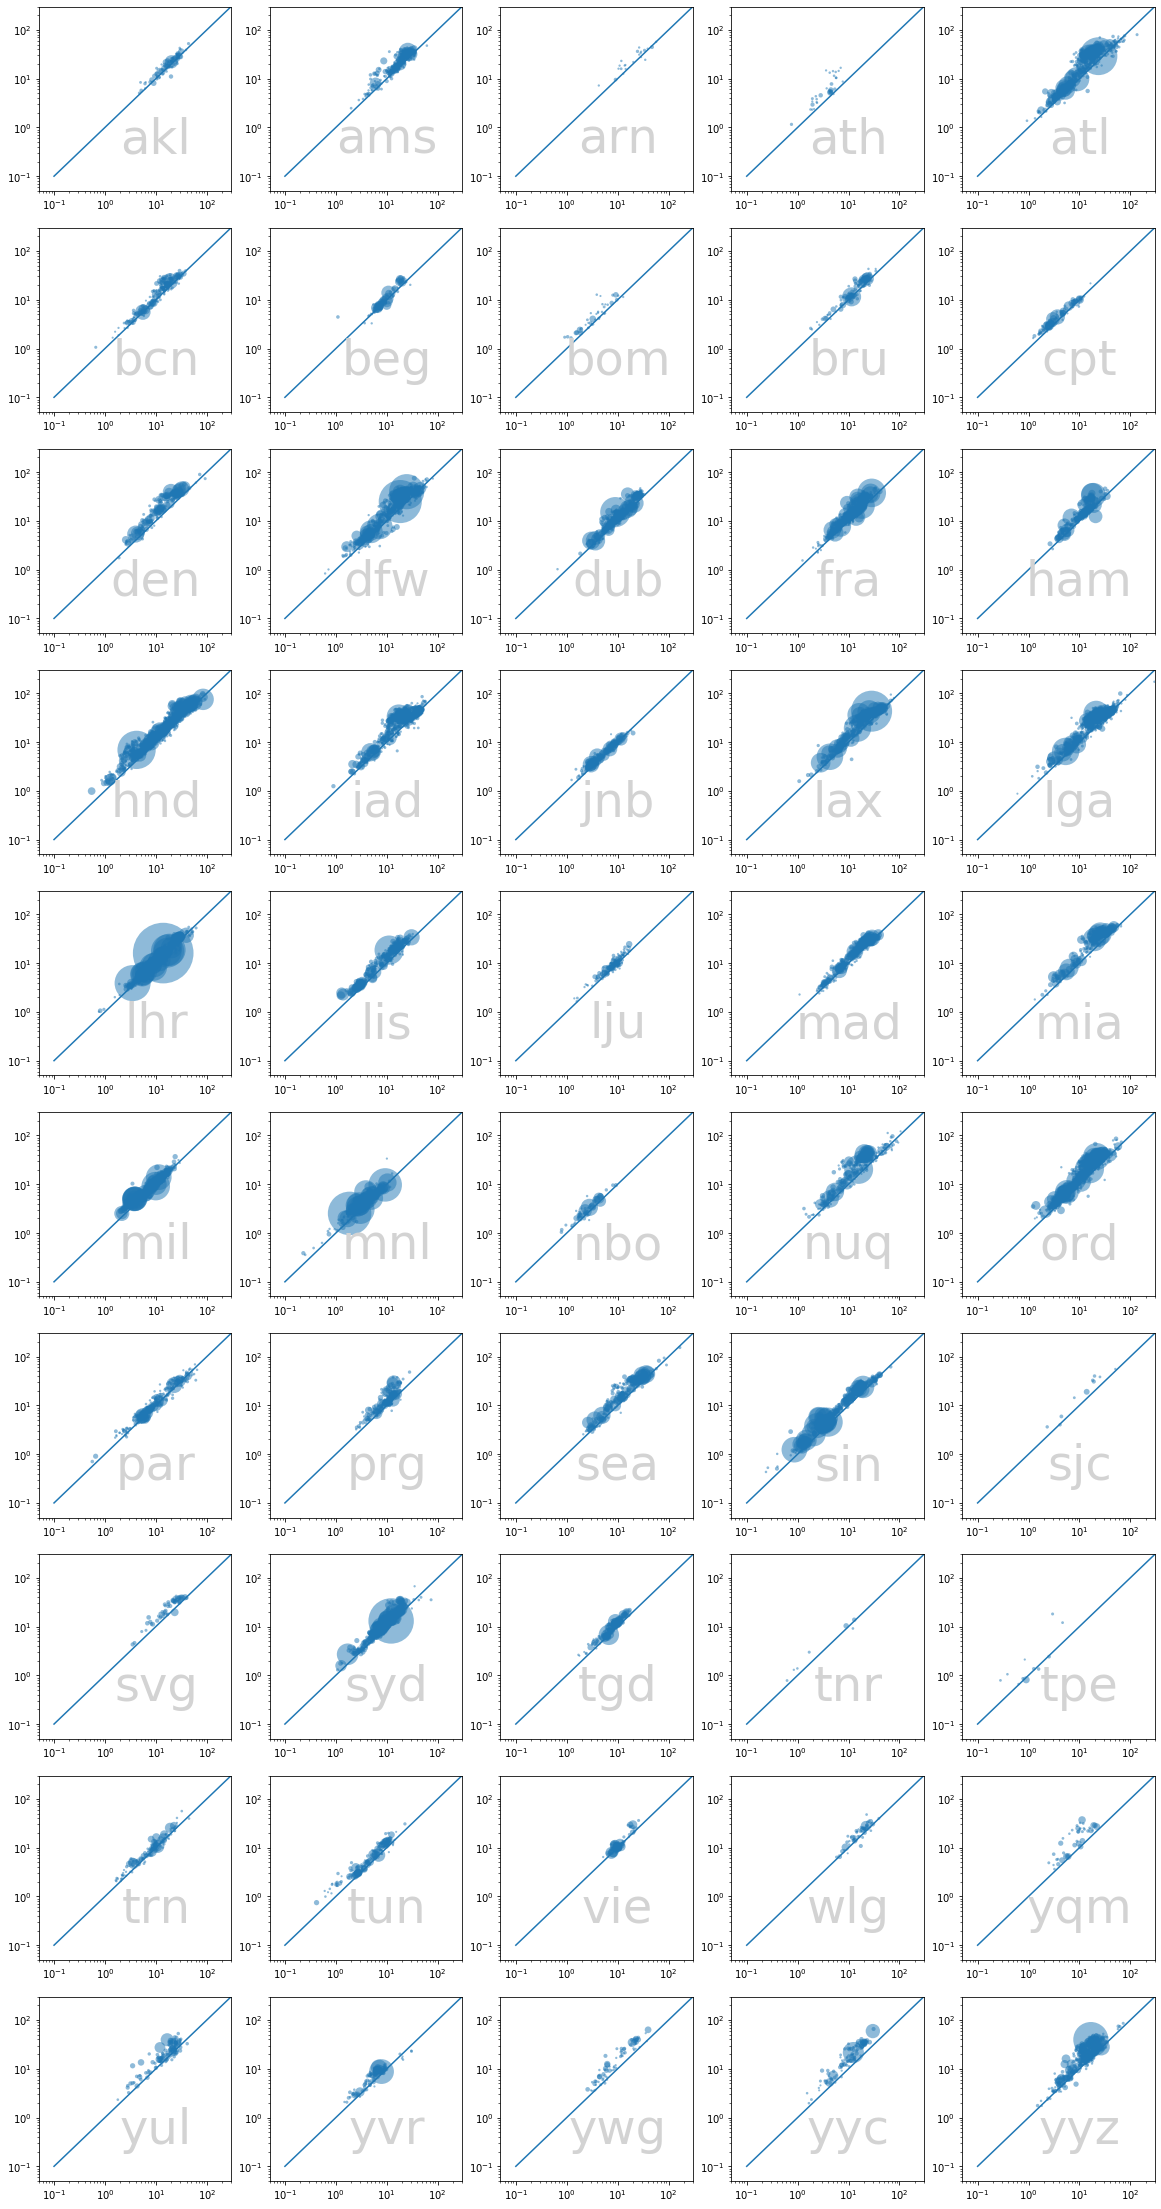

In [3]:
%matplotlib inline
import math
import matplotlib.pyplot as plt

columns = 5
rows = math.ceil(len(prefix_data) / float(columns))
plt.rcParams['figure.figsize'] = [20,4*rows]
for i, site in enumerate(sorted(prefix_data)):
    plt.subplot(rows, columns, i+1)
    plt.xlim(left=.05, right=300)
    plt.ylim(bottom=.05, top=300)
    # plot the diagonal
    plt.loglog([.1,300], [.1,300], label="preferred")
    plt.text(10, .3, site, ha='center', fontsize=48, color='lightgray')
    plt.scatter(prefix_data[site]['pl'], prefix_data[site]['k8'],
               s=prefix_data[site]['size'], alpha = 0.5,
               label=site, linewidth=0)
    
plt.show()


In [4]:
from google.cloud import bigquery
client = bigquery.Client(project='measurement-lab')

quantile_query = client_per_day + '''
###################################################################################
# For each site, compute the 100 quantiles of bandwidth_down
# label by type (pl or ndt5) and report 

wss_quantiles AS (
SELECT 
iata,  site, protocol, type, COUNT(*) AS tests, COUNT(DISTINCT HOUR) as hours,
approx_quantiles(mbps, 100) as quantiles
FROM client_per_day
WHERE duration BETWEEN 9.0 AND 13.5
AND machine IN ("mlab2", "mlab3")
AND log_time BETWEEN "2019-08-03" AND "2019-09-30"
AND protocol = "WSS"
GROUP BY iata, site, protocol, type
),

unnested as (
  SELECT iata, site, protocol, type, quantiles, offset
  FROM wss_quantiles CROSS JOIN UNNEST(wss_quantiles.quantiles) WITH OFFSET AS offset
),

ndt5_unnested AS (
  SELECT * FROM unnested
  WHERE type = "ndt5"
),

pl_unnested AS (
  SELECT * FROM unnested
  WHERE type = "pl"
)

SELECT pl.iata, pl.site, pl.protocol, pl.offset as percentile,
  pl.quantiles AS pl_mbps, ndt5.quantiles AS ndt5_mbps
FROM pl_unnested AS pl INNER JOIN ndt5_unnested AS ndt5 USING (site, offset)
'''

quantile_data = client.query(quantile_query)

from collections import defaultdict as dd
# map of map of array
quantiles = dd(lambda: dd(lambda: [0 for _ in range(101)]))

for row in quantile_data.result(timeout=3000):
    quantiles[row['site']]['pl'][row['percentile']] = row['pl_mbps']
    quantiles[row['site']]['k8'][row['percentile']] = row['ndt5_mbps']


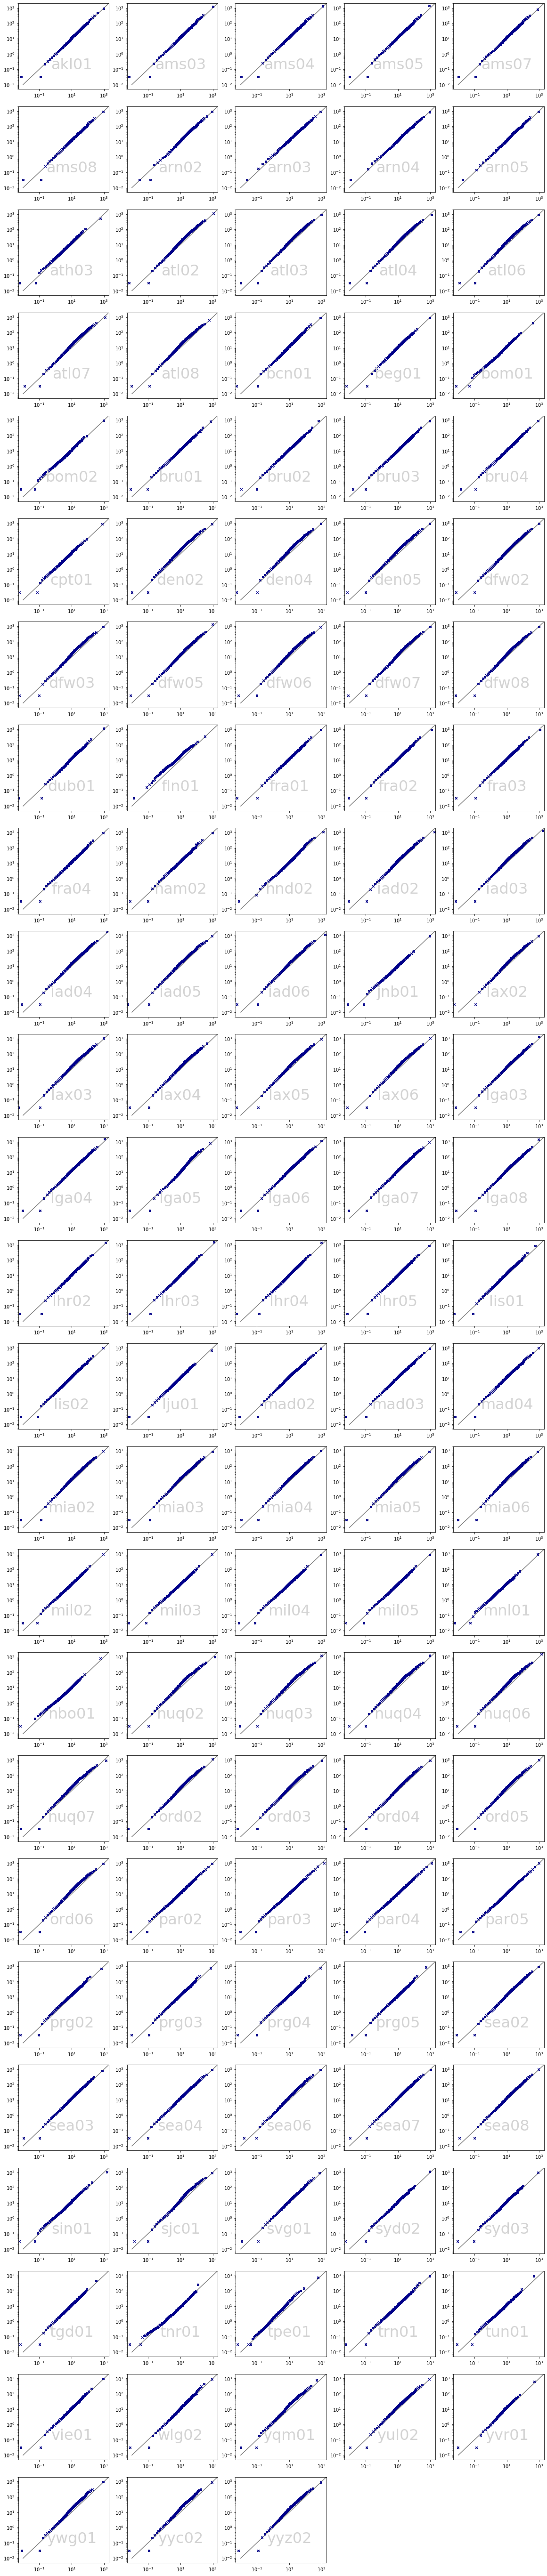

In [7]:

%matplotlib inline
import math
import matplotlib.pyplot as plt

columns = 5
rows = math.ceil(len(quantiles) / float(columns))
plt.rcParams['figure.figsize'] = [20,4*rows]
for i, site in enumerate(sorted(quantiles)):
    plt.subplot(rows, columns, i+1)
    # plot the diagonal
    plt.loglog([.01,10000], [.01,10000], label="preferred", color="gray")
    plt.text(10, .1, site, ha='center', fontsize=32, color='lightgray')
    plt.loglog(quantiles[site]['pl'], quantiles[site]['k8'],
               label=site, color="darkblue", alpha=0.4,
               linewidth=1, marker="x", markersize=4)
    plt.xlim(left=.005, right=2000)
    plt.ylim(bottom=.005, top=2000)
    
plt.show()
    
